In [1]:
!pip3 install wandb -qU
!pip3 install pydicom -qU

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.utils.data
import seaborn as sns
import wandb
from tqdm import tqdm
from torchvision.transforms import v2
import torch.nn as nn
from dataclasses import dataclass
import shutil


In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
print(torch.version.cuda)

12.1


In [6]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu' if torch.cuda.is_available() else 'cuda')
device = 'cpu'
print(device)
torch.set_default_device(device)
torch.multiprocessing.set_start_method('spawn', True)

cpu


In [7]:
!cp drive/MyDrive/Licenta/duke_dbt_data.py .
!cp drive/MyDrive/Licenta/sort_split_data.py .
!cp drive/MyDrive/Licenta/classification_dataset.py .
!cp drive/MyDrive/Licenta/model_aux.py .
!mkdir checkpoints
from classification_dataset import ClassificationDataset
#from "/content/drive/MyDrive/Licenta/classification_dataset.py" import MyDataset

mkdir: cannot create directory ‘checkpoints’: File exists


In [8]:
wandb.login(key = "8a625877a46f5b9236fa4719743bf8c17928ead7")

wandb: Currently logged in as: ioana-baciu4. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [9]:
bs = 128

train_dataset = ClassificationDataset(base_folder="drive/MyDrive/Licenta/", split_name="train", number_of_slices=22, batch_size=bs)
test_dataset = ClassificationDataset(base_folder="drive/MyDrive/Licenta/", split_name="test", number_of_slices=22, batch_size=1)


train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size = bs, shuffle = False, num_workers = 0,
                                              generator=torch.Generator(device=device))
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True,
                                             generator=torch.Generator(device=device))

In [10]:
# from collections import Counter
# for i_batch, sample_batched in enumerate(train_data_loader):
#     imgs = sample_batched[0]
#     segs = sample_batched[1]

#     rows, cols = 1, bs
#     # figure = plt.figure(figsize=(10, 10))
#     all_segs = []
#     segs = segs.cpu().numpy()
#     for seg in segs:
#       all_segs.append(np.argmax(seg))
#     print(Counter(all_segs))
#     # for i in range(0, imgs.shape[0]):
#     #     figure.add_subplot(rows, cols, i + 1)
#     #     plt.axis("off")
#     #     plt.imshow(imgs[i].cpu().numpy()[0])
#     #     print(segs[i])
#     # plt.show()

In [11]:
main_dir = 'drive/MyDrive/Licenta/images/Breast-Cancer-Screening-DBT'
small_dirs = os.listdir(main_dir)
for small_dir in small_dirs:
  dir1 = os.path.join(main_dir, small_dir)
  smaller_dirs = os.listdir(dir1)
  for smaller_dir in smaller_dirs:
    dir2 = os.path.join(dir1, smaller_dir)
    smallest_dirs = os.listdir(dir2)
    for smallest_dir in smallest_dirs:
        dir3 = os.path.join(dir2, smallest_dir)
        smallester_dirs = os.listdir(dir3)
        for file in smallester_dirs:
          dir4 = os.path.join(dir3, file)
          if '(' in file and 'txt' not in file:
            print(dir4)
            os.remove(dir4)
          if dir4.count('(' ) > 1:
            print(dir4)
            os.remove(dir4)
          if os.path.isdir(dir4):
            print(dir4)
            shutil.rmtree(dir4)

In [12]:
@dataclass
class InputParameters:
    model: nn.Module
    optimizer: torch.optim.Optimizer
    scheduler: torch.optim.lr_scheduler.ExponentialLR
def save_checkpoint(model_input, optimizer_input, scheduler_input, filename):
    print("=> Saving checkpoint")
    input_parameters = InputParameters(model_input, optimizer_input, scheduler_input)
    torch.save(input_parameters, filename)
def load_checkpoint(filename):
    print("=> Loading checkpoint")
    input_parameters = torch.load(filename)
    return input_parameters.model, input_parameters.optimizer, input_parameters.scheduler

In [13]:
#CUDA_VISIBLE_DEVICES=0

In [14]:
sweep_config: dict = {
    "project": "licenta",
    "metric":
        {"name": "loss","goal": "minimize"}
    ,
    "method": "grid", # grid/random
     "parameters":
    #     {
    #     "learning_rate": {
    #         "values": [1e-4, 1e-5, 1e-6]
    #         },
    #     "number_of_epochs": {
    #         "values": [8,9,10]
    #         },
    #     },
    None
}
parameters: dict = {
    "learning_rate": {
        "values": [1e-3, 1e-4, 1e-5]
    },
    "number_of_epochs": {
        "values": [50,75,100]
    }
}
sweep_config["parameters"] = parameters
sweep_id = wandb.sweep(sweep_config)

Create sweep with ID: dwt0bkuf
Sweep URL: https://wandb.ai/ioana-baciu4/licenta/sweeps/dwt0bkuf


In [15]:
def train_one_epoch(loader, model_input, optimizer_input, loss_function, scheduler_input, index):
  for data, targets in tqdm(loader):
    data, targets = data.to(device), targets.to(device)
    optimizer_input.zero_grad()
    predictions = model_input(data)
    predictions = nn.Sigmoid()(predictions)
    loss = loss_function(predictions, targets)

    # print(f"Loss: {loss}")
    # print(f"Predicted: {predictions}")
    # print(f"Real class: {targets}")

    loss.backward()
    optimizer_input.step()

    wandb.log({"loss": loss.item()})
  scheduler_input.step()

In [16]:
from tensorflow import Tensor


def get_accuracy(real_target: Tensor, predicted_target: Tensor):
    # noinspection PyTypeChecker
    correctly_predicted = torch.sum(real_target == predicted_target).item()
    all_targets = real_target.numel()
    return correctly_predicted / all_targets


def get_precision(real_target: Tensor, predicted_target: Tensor):
    # noinspection PyTypeChecker
    all_positive_predicted = torch.sum(predicted_target == 1).item()
    # noinspection PyTypeChecker
    true_positive_targets = torch.sum(
        (real_target == predicted_target) &
        (real_target == 1)).item()
    precision = true_positive_targets / max(all_positive_predicted, 1)
    return precision


def get_recall(real_target: Tensor, predicted_target: Tensor):
    # noinspection PyTypeChecker
    all_positive_targets = torch.sum(real_target == 1).item()
    # noinspection PyTypeChecker
    true_positive_targets = torch.sum(
        (real_target == predicted_target) &
        (real_target == 1)).item()
    recall = true_positive_targets / max(all_positive_targets, 1)
    return recall


def get_confusion_matrix(real_target: Tensor, predicted_target: Tensor):
    confusion_matrix = np.empty((2, 2), dtype=np.uint16)
    cancer_predicted_values, normal_predicted_values = get_predicted_classes_for_all_classes(predicted_target, real_target)
    for i in range(0, 2):
        set_confusion_matrix_values(cancer_predicted_values,
                                    confusion_matrix, i, normal_predicted_values)
    return confusion_matrix


def set_confusion_matrix_values(cancer_predicted_values,
                                confusion_matrix, i, normal_predicted_values):
    # noinspection PyTypeChecker
    confusion_matrix[0][i] = torch.sum(normal_predicted_values == i).item()
    # noinspection PyTypeChecker
    confusion_matrix[1][i] = torch.sum(cancer_predicted_values == i).item()


def get_predicted_classes_for_all_classes(predicted_target, real_target):
    normal_predicted_values = get_predicted_class_for_normal_class(predicted_target, real_target)
    cancer_predicted_values = get_predicted_class_for_cancer_class(predicted_target, real_target)
    return cancer_predicted_values, normal_predicted_values


def get_predicted_class_for_cancer_class(predicted_target, real_target):
    cancer_real_indexes = (real_target == 1).nonzero()
    cancer_predicted_values = predicted_target[cancer_real_indexes]
    return cancer_predicted_values

def get_predicted_class_for_normal_class(predicted_target, real_target):
    normal_real_indexes = (real_target == 0).nonzero()
    normal_predicted_values = predicted_target[normal_real_indexes]
    return normal_predicted_values

def check_metrics(loader, model_aux, index):

    with torch.no_grad():
        all_predicted_classes = torch.tensor([]).to(device)
        all_real_classes = torch.tensor([]).to(device)
        for data, targets in tqdm(loader):
            data, real_class = data.to(device), targets.to(device).argmax(dim=1)
            predicted_class = model_aux(data).to(device)
            predicted_class = nn.Sigmoid()(predicted_class).argmax(dim=1)

            all_predicted_classes = torch.cat((all_predicted_classes, predicted_class))
            all_real_classes = torch.cat((all_real_classes, real_class))

        accuracy = get_accuracy(all_real_classes, all_predicted_classes)
        precision = get_precision(all_real_classes, all_predicted_classes)
        recall = get_recall(all_real_classes, all_predicted_classes)
        confusion_matrix = get_confusion_matrix(all_real_classes, all_predicted_classes)
    return accuracy, precision, recall, confusion_matrix

In [17]:
run_id = 0
index = 1
def train_with_metrics():
    run = wandb.init(config=sweep_config)
    run_id = run.id
    print(run_id)
    loss_function = nn.CrossEntropyLoss()
    #learning_rate = wandb.config.learning_rate
    #number_of_epochs = wandb.config.number_of_epochs
    number_of_epochs = 5
    for epoch in range(number_of_epochs):
        model_pret.train()
        print(f"=> Training epoch: {epoch+1}")
        train_one_epoch(train_data_loader, model_pret, optimizer, loss_function, scheduler, index)
        print("=> Finished training...")
        model_pret.eval()
        print("=> Calculating metrics...")
        accuracy, precision, recall, confusion_matrix = check_metrics(test_data_loader, model_pret, index)
        wandb.log({"accuracy": accuracy, "precision": precision})
        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        save_checkpoint(model_pret, optimizer, scheduler, f"./checkpoints/acc_{epoch}_aux{index}.pth")
        plt.figure(figsize=(7, 5))
        sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g',
                xticklabels=['normal', 'cancer'],
                yticklabels=['normal', 'cancer'])
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.show()
    run.finish()

In [18]:
from model_aux import GoogLeNet
from torchvision.models import GoogLeNet_Weights

# model = GoogLeNet().to(device)
model_pret = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', weights=GoogLeNet_Weights.IMAGENET1K_V1)
model_pret.fc = nn.Linear(in_features=1024, out_features=2)
#def get_batch_sizes():
    #run = wandb.init(config=sweep_config)
#bs = wandb.config.batch_sizes

#wandb.agent(sweep_id, function=train_with_metrics, count=5)
    #run.finish()
learning_rate = 0.0001
optimizer = torch.optim.Adam(model_pret.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# train_with_metrics(model, optimizer_to_train=optimizer, scheduler_to_train=scheduler)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [19]:
from torchsummary import summary
summary(model_pret, (3, 300, 300))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 150, 150]           9,408
       BatchNorm2d-2         [-1, 64, 150, 150]             128
       BasicConv2d-3         [-1, 64, 150, 150]               0
         MaxPool2d-4           [-1, 64, 75, 75]               0
            Conv2d-5           [-1, 64, 75, 75]           4,096
       BatchNorm2d-6           [-1, 64, 75, 75]             128
       BasicConv2d-7           [-1, 64, 75, 75]               0
            Conv2d-8          [-1, 192, 75, 75]         110,592
       BatchNorm2d-9          [-1, 192, 75, 75]             384
      BasicConv2d-10          [-1, 192, 75, 75]               0
        MaxPool2d-11          [-1, 192, 37, 37]               0
           Conv2d-12           [-1, 64, 37, 37]          12,288
      BatchNorm2d-13           [-1, 64, 37, 37]             128
      BasicConv2d-14           [-1, 64,

wandb: Agent Starting Run: e5ipdxmg with config:
wandb: 	learning_rate: 0.001
wandb: 	number_of_epochs: 50


e5ipdxmg
=> Training epoch: 1


100%|██████████| 94/94 [2:15:48<00:00, 86.69s/it]


=> Finished training...
=> Calculating metrics...


100%|██████████| 3322/3322 [18:05<00:00,  3.06it/s]


Accuracy: 0.5391330523780855
Precision: 0.8391608391608392
Recall: 0.07371007371007371
=> Saving checkpoint


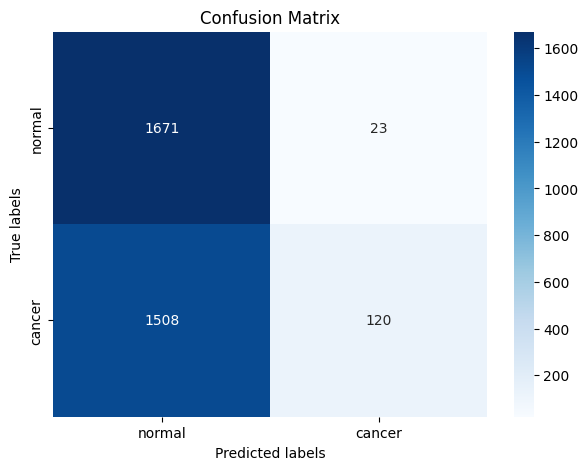

=> Training epoch: 2


100%|██████████| 94/94 [1:59:28<00:00, 76.26s/it]


=> Finished training...
=> Calculating metrics...


100%|██████████| 3322/3322 [12:16<00:00,  4.51it/s]


Accuracy: 0.5264900662251656
Precision: 0.5096933380331335
Recall: 0.8882063882063882
=> Saving checkpoint


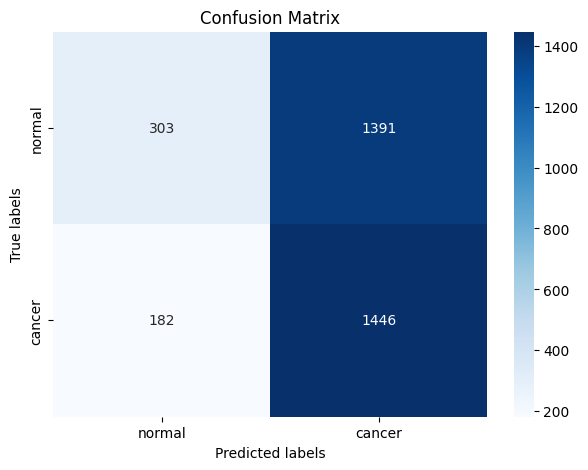

=> Training epoch: 3


 94%|█████████▎| 88/94 [1:49:45<07:25, 74.23s/it]

In [ ]:
wandb.agent(sweep_id, function=train_with_metrics, count=1)